**INTRO**

This notebook steps through how to pre-process data, run the self-organising map algorithm and evaluate the output using atmospheric data from reanalysis models. 

In this session we will go through the basic considerations and data preparations required for running a SOM, using daily weather maps as the example input.  


---
***Background info***

*What is a Self Organising Map?*

A self-organising map (SOM) is a type of artificial neural network that is trained using unsupervised learning to produce a reduced dimensional, discretised representation of the input dataset.  In climate science, SOMs are often used to identify key regional weather patterns (e.g. High pressure/Low pressure systems) in an area of interest (without having to manually look at each daily weather map)

*Why use a Self Organising Map?*

A key assumption when classifying weather types is that daily weather patterns can be split into a specified number of "types". For this reason the SOM algorithm is often preferred for classifying weather over traditional discrete clustering methods (e.g. k-means). SOMs are able to account for continuity and nonlinearity (Jiang et al. 2012) more than clustering which provides a more realistic representation of the continuous movement of weather patterns.  

*What package is the best to use?*

The 'Kohonen' R package is very popular in climate science.  The documentation is available here: https://cran.r-project.org/web/packages/kohonen/kohonen.pdf

Side note: I bashed my head against the wall trying to get SOMs to work in python for 3+ months (using pySOM, miniSOM, SOMPY) but I couldn't get the packages to produce stable results. So I taught myself R to run SOMs (apologies in advance for messy coding)

---
Thanks to Peter Gibson for providing the initial SOM code in R to get me started.  You can find his paper on using SOMs for studying climate extremes here: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD026256


ERROR: ignored

In [ ]:
## Set up access to GoogleDrive to download data for tutorial

#Step 1: Initialise
#install the Httpuv library - it allows R code to interact with HTTP and Websocket clients
install.packages("googledrive")
install.packages("httpuv")
library("googledrive")
library("httpuv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘promises’, ‘later’




In [ ]:
#Change local path - this can change with updates so might become out of date 
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) { #may update python version  
                                       #occasionally
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




In [ ]:
# call authentication forcing interactive login and save in cache. 
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWggUnU6D7m688PeQHkM5l60CWfCZAhkYQSPTj99FDksGatD0CZMghM


**DATA PRE-PROCESSING**

Prior to loading into R the following steps are generally required (depending on your research questions): 

1. Download reanalysis data/variables of interest (e.g. ECWMF: https://apps.ecmwf.int/datasets/, or stored on NCI if you have access)
2. Calculate daily anomalies to remove seasonality influence on the SOM output.  The seasonal signal will dominate the variability detected by the SOM algorithm so unless you are interested in seasonality remove prior to running the SOM. I used the Climate Data Operators tools to calculate (https://code.mpimet.mpg.de/projects/cdo/) 

FYI: Some useful cdo functions for processing netcdf data prior to loading into R

 - to merge multiple netcdf files together over time: 
 
 cdo -b F64 mergetime infiles*.nc mergetime_file.nc 

 - to select a region (e.g SH): 

 cdo -sellonlatbox,0,360,-90,0 mergetime_file.nc mergetime_regional_file.nc

- to calculate daily anomalies: 
 - a) convert 6hr dataset to daily using cdo daymean
 - b) create a file of daily climatology using cdo ydaymean
 - c) calculate the daily anomaly using cdo ydaysub infile1.nc climatologyfile.nc outfile.nc

  e.g. cdo -r -f nc4 -b 64 ydaysub z_500_dailymean_ERAI_historical_an-pl_1979-2018_SH.nc z_500_dailymeanstat_ERAI_historical_an-pl_1979-2018_SH.nc daily_anomaly_file.nc

In [ ]:
#load data file
#first we need to install/load the package to read netcdf files
install.packages("ncdf4")
library("ncdf4")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#check working directory
getwd()

[1] "/content"

In [ ]:
#working directory is the content folder
#File information
f_name = "z_500_dailyanomaly_ERAI_1979-2018_AAT.nc"
ncfile_google = drive_get("~/Datasets/z_500_dailyanomaly_ERAI_1979-2018_AAT.nc")
drive_download(ncfile_google)
ncfile_colab = nc_open("/content/z_500_dailyanomaly_ERAI_1979-2018_AAT.nc")





✔ The input `path` resolved to exactly 1 file.

File downloaded:

• z_500_dailyanomaly_ERAI_1979-2018_AAT.nc
  <id: 11awYMzOSxoQGTLno1EguzMhQdWYAM6YI>

Saved locally as:

• z_500_dailyanomaly_ERAI_1979-2018_AAT.nc



In [ ]:
# Now we have the dataset saved locally lets define variables from the ncfile

#first lets rename the dataset to make it easier to track through
nc = ncfile_colab
#now lets load variables - first up the pressure at 500hPa which is stored as z in the netcdf file
z500 = ncvar_get(nc, varid = "z")
t = ncvar_get(nc, "time")
lon = ncvar_get(nc, "lon")
lat = ncvar_get(nc, "lat")
tunits = ncatt_get(nc, "time", "units")
tunits_ref = strsplit(tunits$value, " ")
tunits_ref_string = paste(unlist(tunits_ref)[3],unlist(tunits_ref)[4])
paste("time unit is in...", unlist(tunits_ref)[1],unlist(tunits_ref)[2],tunits_ref_string)

[1] "time unit is in... hours since 1900-01-01 00:00:00"

In [ ]:
# Change the dates from hours since to 'normal' date format
posixct_datetime = as.POSIXct(t*3600, origin=tunits_ref_string, tz = "GMT")
#NOTE: *3600 is specific for "hours since" format used in ERA-Interim datasets
#Check data format - e.g. MERRA reanalysis is in "minutes since' format - use 3600/60 

datetime = as.numeric(format(as.Date(as.character(posixct_datetime)),"%Y%m%d"))
#specify the format - e.g. Year, Month, Day

z500_dates = as.numeric(as.character(datetime))
z500_dates[1:5] #return the first 5 timesteps to check

[1] 19790101 19790102 19790103 19790104 19790105

In [ ]:
#convert geopotential pressure to geopotential height by dividing by gravity
g = 9.80665
z500_daily = z500/g

In [ ]:
#Next lets check the dimensions of the z500_daily dataset
dim(z500)

[1]   180    61 14549

In [ ]:
#Lets create a subset of the full dataset for the tutorial
end_timestep = 3653 #31/12/1988
idx_first10yrs = c(1:end_timestep) #first 10 years 1/1/1979 to 31/12/1988
z500_daily_subset = z500_daily[,,idx_first10yrs]
z500_dates_subset = z500_dates[idx_first10yrs]
dim(z500_daily_subset)

[1]  180   61 3653

In [ ]:
#Now save the dimensions to use later
nlon = dim(z500_daily_subset)[1] #longitude is the first dimension (remember is R is 1 indexed, not 0 indexed like python)
nlat = dim(z500_daily_subset)[2] #latitude is saved as the second dimension
nt = dim(z500_daily_subset)[3] #time is the 3rd dimension - daily data from 1/1/1979 to 31/10/2018

#print out one of the variables
nlon

[1] 180

In [ ]:
#Currently the dataset 3 dimensional - lat, lon, time. 
#But the SOM algorithm input requires the dataset to be one dimensional
# So lets convert 3D dataset to 1D

#this converts the dataset from a distributed matrix to a non-distributed matrix
#which we need for the next step
tmp.vec.long = as.vector(z500_daily_subset) 
#collapse dataset
#each row will be a unique lat/lon combination (e.g. lat1/lon1 lat2/lon1 lat3/lon1)
#each column will be a daily timestep (e.g. 1/1/1979, 2/1/1979, 3/1/1979)
tmp.mat = matrix(tmp.vec.long, nrow = nlon * nlat, ncol = nt)

#transpose dataset - we actually want time to be rows, lat/lon combinations to be columns
z500_daily_subset1d = data.frame(t(tmp.mat))
head(z500_daily_subset1d)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X10971,X10972,X10973,X10974,X10975,X10976,X10977,X10978,X10979,X10980
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.55705,14.902196,15.979272,16.808588,17.4176292,17.729917,17.819142,17.747045,17.543102,17.228026,⋯,39.00813,39.91193,40.75399,41.58291,42.40625,43.25628,44.13061,45.05234,46.00513,46.99737
2,-13.49093,-9.868543,-6.300333,-2.926506,0.1278629,2.870342,5.247954,7.165896,8.686707,9.824328,⋯,104.58703,106.32812,108.04610,109.76448,111.50039,113.24705,114.99571,116.74595,118.46991,120.15165
3,-96.68065,-86.290298,-76.236533,-67.079800,-58.9419871,-51.325583,-44.255684,-38.010320,-32.413831,-27.492107,⋯,126.13730,126.87819,127.56411,128.21059,128.82601,129.43704,130.07436,130.69296,131.31396,131.89711
4,-223.33538,-229.759191,-231.858771,-229.082832,-220.9593586,-208.130054,-192.128874,-174.597722,-156.396983,-137.991503,⋯,94.62010,95.88957,97.09650,98.26280,99.39843,100.49901,101.57130,102.62209,103.61113,104.51733
5,-123.48325,-134.126938,-144.024559,-152.800890,-160.4376080,-166.916391,-171.934112,-175.121123,-176.036478,-174.033293,⋯,38.56997,39.90954,41.31125,42.76315,44.26405,45.79920,47.36622,48.92806,50.48193,51.98681
6,-86.73563,-87.363788,-88.064046,-88.921644,-89.9369784,-91.110449,-92.353626,-93.503595,-94.467944,-95.140319,⋯,-35.53313,-36.13898,-36.65840,-37.06907,-37.37021,-37.54547,-37.56818,-37.47736,-37.24872,-36.87071


In [ ]:
### Now we have the dataset ready for the SOM algorithm

#lets load the "kohonen" package for SOM analysis
install.packages("kohonen")
library("kohonen")

#also load some other useful packages
install.packages("viridis")
library("viridis") #colour pallettes for plotting
install.packages("ggcorrplot")
library("ggcorrplot")
library("ggplot2")
install.packages("reshape") #reshape datasets
library("reshape")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gridExtra’


Loading required package: viridisLite

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’


Loading required package: ggplot2



In [ ]:
# SET UP SOM PARAMETERS

#SOM sequential mode: training is goverened by: 
# 1. learning rate parameter (alpha)
# 2. neighbourhood radius (radius)
# 3. number of iterations (rlen)

#default parameters:
#rlen = 100
#alp = c(0.05,0.01)
#rad = c(5,1)

#Number of Nodes and structure of grid
#e.g. 9 nodes with a 3x3 grid
Nnodes = 9
nx = 3
ny = 3

# number of iterations - rlen
rlen = 100             # number of times the complete dataset will be presented to the network
#rlen -> use 100 for initial testing/demo -> increase to 1000+ when actually running

# learning rate parameter - alpha
alp = c(0.05,0.01)     # learning rate -> magnitude each node pattern is updated 
# Requires vector of two numbers indicating the amount of change
# Default (decrease from 0.05 to 0.01 linearly over rlen updates)

# neighbourhood radius - radius
rad = c(4,0)             # Number of surrounding nodes activated - # 75% SOM, 25% clustering.
# value < 1 no surrounding nodes activated = k-means clustering
#100% SOM example: rad = c(4,1)

#grid structure of SOM ("rect", "hexagonal)
gr = "rect"  #update manually in SOM algorithm.  This is for filename setup. 

#data type - "raw","detrended","daily_anomaly"
dt = "daily_anomaly"  #this is for filename setup


#NOTE: this code is using the single - sequential method.  
#Can also run in batch - refer to the documentation

In [ ]:
### RUNNING THE SOM & SAVING VARIABLES
set.seed(5) #this is important for consistent results between runs

#input data 
data = z500_daily_subset1d

#SOM algorithm
print("running SOM algorithm.......")
K_SOM = som(X = data.matrix(data),
            grid = somgrid(nx,ny,"rect","gaussian"),
            rlen = rlen,
            alpha = alp,
            radius = rad,
            keep.data = T,
            dist.fcts = c("euclidean"),
            normalizeDataLayers = FALSE)

print("finished running SOM")

#Takes about 2 minutes with 10 years of daily data


[1] "running SOM algorithm......."
[1] "finished running SOM"


In [ ]:
#Save variables
K_SOM_d    <- data.frame(K_SOM$distances)        # get errors -> distances between grids
K_SOM_SOM  <- data.frame(K_SOM$codes)            # get clusters grid
tmp        <- data.frame(t(K_SOM_SOM))           # transpose
K_SOM_SOMc <- data.frame(unlist(tmp))           # concatenate codebook vectors to 1 row
K_SOM_win  <- data.frame(K_SOM$unit.classif)     # get clusters win
K_SOM_grid <- data.frame(K_SOM$grid[["pts"]])    # get grid structure
print(K_SOM_grid)  #order - columns then rows -> 1-3 first row, 4-6 - second row etc


winning_nodes <- cbind(as.character(z500_dates_subset),K_SOM_win)      #finds the winning nodes of each timestep - daily data      
colnames(winning_nodes) <- c("date","node")   #adds date and node to column heading

  x y
1 1 1
2 2 1
3 3 1
4 1 2
5 2 2
6 3 2
7 1 3
8 2 3
9 3 3


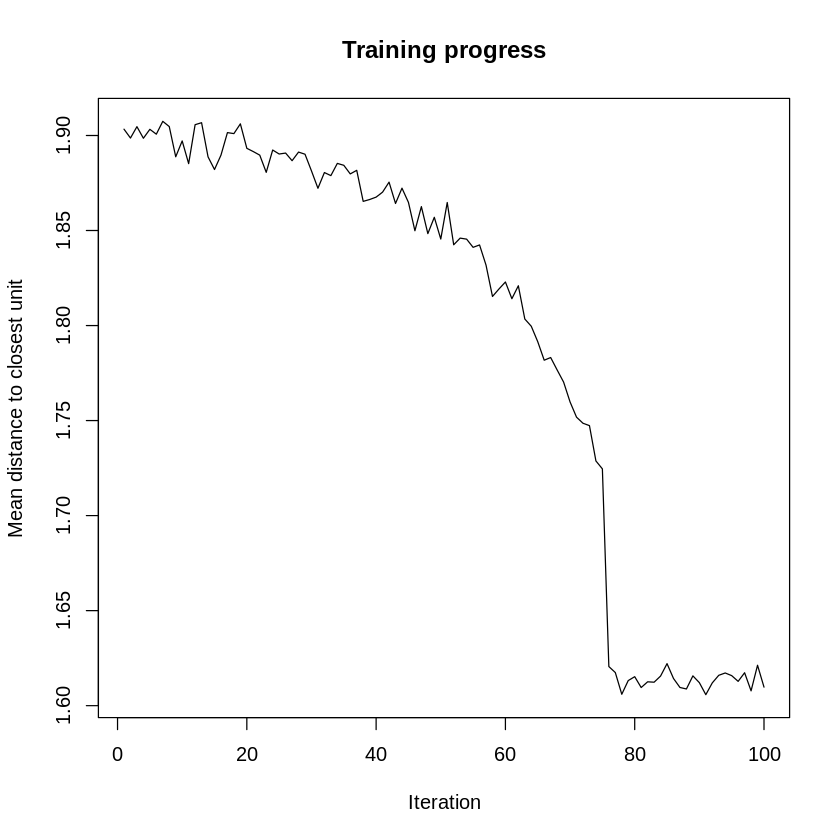

In [ ]:
#Check the training progress (unlikely to reach optimal level with only 100 iterations)
#changes - training process -> mean distance to closest unit
#png(paste("SOM_training_",filename_end, sep=""), width = 888, height = 428)
plot(K_SOM, type="changes")
#dev.off()

In [ ]:
###  create index for each node and use this to index to z500 dataset ###

# SOM index and daily z500 anomaly fields
idx_SOM <- lapply(1:Nnodes, function(x){idx_SOM_tmp <- which(winning_nodes$node == x)})
z500_SOM <- lapply(1:Nnodes, function(x){z500_SOM_tmp <- z500_daily_subset[,,which(winning_nodes$node == x)]})

In [ ]:
### calculate mean of each grid cell over time for each SOM ###

#define function
means.along <- function(a, i ){
  n <- length(dim(a))
  b <- aperm(a,c(seq_len(n)[-i],i))  #move 3rd dimension to the end. Probably not needed in this case
  rowMeans(b, dims=n-1)
}

#calculate mean over time dimension (3rd dimension) - using above function
SOM_z500_mean <- lapply(1:Nnodes, function(x)
{SOM_mean_tmp <- means.along(z500_daily_subset[,,which(winning_nodes$node == x)],3)})

Saving 6.67 x 6.67 in image



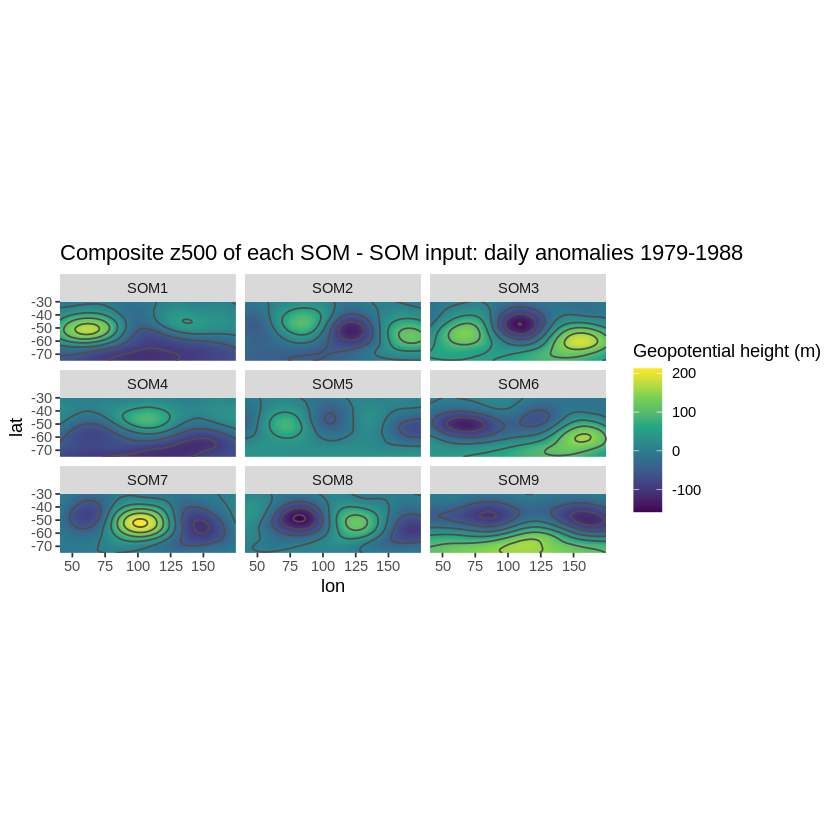

In [ ]:
### create dataframe of all composite SOMs ###
## convert datasets from matrix to vectors ##

## sorry this part of the code becomes a bit messy!
out_dir = '/content'

#latitude
M_lat = NULL
for(sp in 1:length(lat))
{
  M_lat =  c(M_lat, rep(lat[sp],nlon))
}

#longitude
M_lon = rep(lon,nlat)

#create a dataframe of lat & lon
df_ll = data.frame(M_lat,M_lon)

#SOMs - convert matrix to vector -> stored as a list (replace code below)
M_SOMp <-lapply(1:Nnodes, function(x)
  SOM_tmp <- as.vector(SOM_z500_mean[x]))

##anomaly dataframe - SOM run on
df_tmp <- data.frame(t(matrix(unlist(M_SOMp),nrow=length(M_SOMp), byrow=T)))

#combine dataframes
df_SOMs = cbind(df_ll,df_tmp)

#add column names
namestemp<-names(df_tmp)   #get column names for SOM temp dataframe
namestemp2<-sub("X","",namestemp)   #remove X from colnames
namestmp<-c("lat","lon",paste0("SOM",namestemp2))    #add lat, lon & SOM column names (variable)
colnames(df_SOMs)<-namestmp    #add column names to combined dataframe

# names(df)<-c("lat","lon",paste0("SOM",sub("X","",names(df_tmp))))   #above code as one 1 line

#df = data.frame(M_lat,M_lon,M_p1,M_p2,M_p3,M_p4,M_p5,M_p6,M_p7,M_p8,M_p9,M_p10,M_p11,M_p12)
#colnames(df) = c("lat","lon","SOM1","SOM2","SOM3","SOM4","SOM5","SOM6","SOM7","SOM8","SOM9","SOM10","SOM11","SOM12")

#### Add index to dataframe ####
#create a dataframe of 12 SOMs - could adapt code to read length? of Nnodes
Maps<-data.frame("lat"=NA,"lon"=NA,"z500SOM"=NA,"ID"=NA)
for (i in 1:Nnodes){
  namevar<-paste0("SOM",i)
  db<-data.frame("lat"=df_SOMs$lat,"lon"=df_SOMs$lon,"z500SOM"=df_SOMs[names(df_SOMs)==namevar],"ID"=namevar)
  names(db)[names(db)==namevar]<-"z500SOM"
  Maps<-rbind(Maps,db)
  rm(db,namevar)
  
}

Maps<-Maps[!is.na(Maps$lat),]  #remove Na from dataframe
Maps$ID = as.factor(Maps$ID)   #return factor values - order of dataset
#reorder - difficult to automate

#don't need to reorder if SOM nodes <10
#if 12 SOMs
#Maps$ID = factor(Maps$ID,levels(Maps$ID)[c(1,5:12,2:4)])  #reorder the factor values to be 1-12

#if 20 SOMs
#Maps$ID = factor(Maps$ID,levels(Maps$ID)[c(1,5:12,2:4)])  #reorder the factor values to be 1-12

#data("wrld_simpl")
#wrld <- fortify(wrld_simpl)

setwd(out_dir)
### plot only working if coastlines are removed - coastlines work on non facet plots


# create subplot of 9 SOMs - no. of columns and rows from nx, ny variables
ggplot(Maps, aes(x = lon, y = lat, z = z500SOM, fill= z500SOM)) + 
  geom_raster() + 
  scale_fill_viridis_c() +
  #geom_polygon(data =wrld, aes(x = long, y = lat, group = group), fill = "grey", colour = "black", alpha = 0.8) +
  geom_contour(colour="grey30") +
  coord_fixed(ratio = 1,xlim = c(min(lon),max(lon)),ylim = c(min(lat),max(lat)), expand = FALSE, clip="on")+
  facet_wrap(~ID, nrow = ny,ncol = nx)+
  labs(fill = "Geopotential height (m)")+
  ggtitle("Composite z500 of each SOM - SOM input: daily anomalies 1979-1988")

#save figure
ggsave(paste0("SOM_composite_z500_tutorial_test",rundate,"_",filename_end))

In [ ]:
### EXAMINE REALISM OF SOM
#Method: Pearson Pattern Correlation - refer to Gibson et al. 2017; Udy et al. 2021

#### Correlation - loop ============================================ ####

#input datasets: 
#SOM composite map 
#daily z500 map 

#end_timestep defined above when we subsetted the dataset

SOM_cor<-data.frame("SOM"=rep(NA,end_timestep),"time"=NA,"cor"=NA)

i<-1
for (l in c(1:Nnodes)){
  
  for (t2 in 1:length(z500_SOM[[l]][1,1,])){
    
    
    SOM_cor$SOM[i]<-l
    SOM_cor$time[i]<-t2
    SOM_cor$cor[i]<-cor(as.vector(z500_SOM[[l]][,,t2]),
                     as.vector(SOM_z500_mean[[l]]),
                     use = "everything",
                     method = "pearson")
    i<-i+1
    
  }
  
}

head(SOM_cor)

,SOM,time,cor
,<int>,<int>,<dbl>
1,1,1,0.5565180
2,1,2,0.7027749
3,1,3,0.5203754
4,1,4,0.7303217
5,1,5,0.5127031
6,1,6,0.6016919


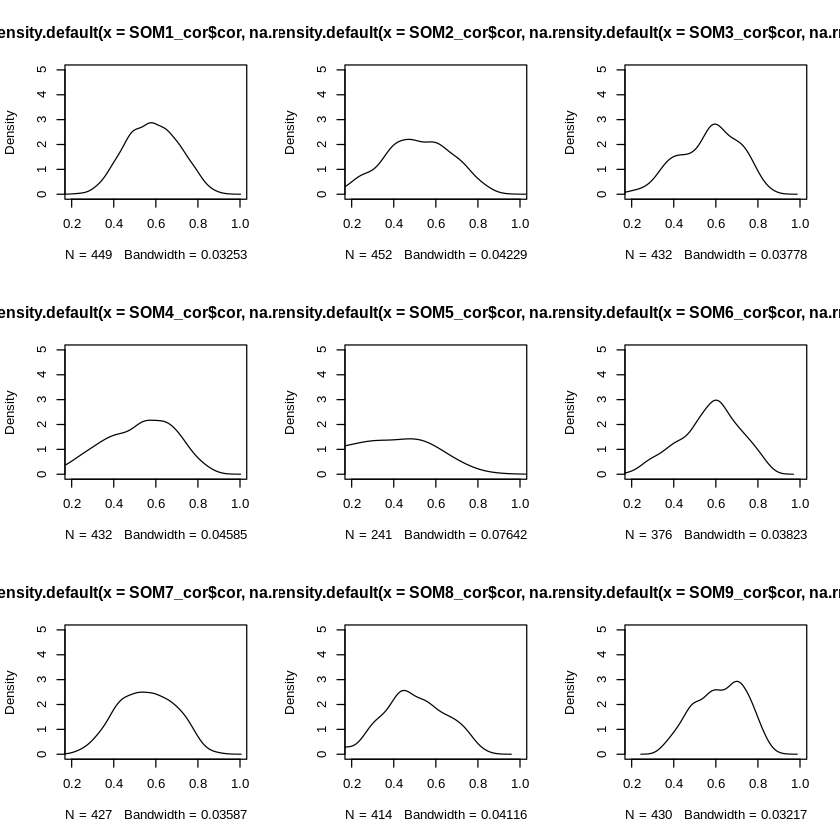

In [ ]:
#DENSITY PLOTS OF CORRELATION RESULTS - these should improve with a higher iteration numbers
#SOM specific plots - anomaly
#create subset datasets - can't combine into dataframe as they don't have equal number of rows. 
SOM1_cor = subset(SOM_cor,SOM == 1)
SOM2_cor = subset(SOM_cor,SOM == 2)
SOM3_cor = subset(SOM_cor,SOM == 3)
SOM4_cor = subset(SOM_cor,SOM == 4)
SOM5_cor = subset(SOM_cor,SOM == 5)
SOM6_cor = subset(SOM_cor,SOM == 6)
SOM7_cor = subset(SOM_cor,SOM == 7)
SOM8_cor = subset(SOM_cor,SOM == 8)
SOM9_cor = subset(SOM_cor,SOM == 9)

#Plot 3x3 subplot
par(mfrow = c(3,3))
plot(density(SOM1_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM2_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM3_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM4_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM5_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM6_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM7_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM8_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))
plot(density(SOM9_cor$cor,na.rm = T), xlim = c(0.2,1),ylim = c(0,5))

In [ ]:
#SOM node and winning timesteps plots

#create lat & lon columns - consistent for all timesteps
t_lat = NULL
for(sp in 1:length(lat))
{
  t_lat =  c(t_lat, rep(lat[sp],nlon))
}
t_lon = rep(lon,nlat)

#create figures in loop - for selected timesteps - 1, 50, 100, 200 in example below
for (n in c(1:Nnodes)){
  
  for (t in c(1,50,100,200)){
    #define timestep
    t_500 = z500_SOM[[n]][,,t]
    t_p = as.vector(t_500)
    t_idx = idx_SOM[[n]][t]
    timestep = as.character(winning_nodes[t_idx,'date'])  #n row, 1st column.  as.character converts to single value instead of a factor
    
    
    #winning SOM node
    SOMwin = n   
    S = SOM_z500_mean[[n]]
    S_p = as.vector(S)
    
    #correlation
    Cor_t <- cor(S_p,t_p,
                 use = "everything",
                 method = "pearson")
    
    #create dataframe
    df_t = data.frame(t_lat,t_lon,S_p,t_p)
    colnames(df_t) = c("lat","lon","SOMw","t500")
    
    #reshape data
    mdata = melt(df_t, id=c("lat","lon"))
    
    #facet plot
    ggplot(mdata, aes(x = lon, y = lat, z = value, fill= value)) + 
      geom_raster() + 
      scale_fill_viridis_c() +
      #geom_polygon(data =wrld, aes(x = long, y = lat, group = group), fill = "grey", colour = "black", alpha = 0.8) +
      geom_contour(colour="grey30") +
      coord_fixed(ratio = 1,xlim = c(min(lon),max(lon)),ylim = c(min(lat),max(lat)), expand = FALSE, clip="on")+
      facet_wrap(~variable, nrow = 2,ncol = 1)+
      labs(fill = "Geopotential Height (m)")+
      annotate("text",x = 150,y= -70, 
               colour = "white",
               label = paste("Pearson Correlation: ",round(Cor_t,4)))+
      ggtitle(paste("Winning SOM",SOMwin,"& daily z500",timestep))
    
    
    #save figure 
    ggsave(paste("Winning_SOM_tutorial_test_",SOMwin,"_timestep_",timestep,".png", sep=""))
    
  }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

In [ ]:
#SET UP FILENAMES FOR OUTPUT FILES/PLOTS
rundate = '2021-08-30' #update for each run
run_num = 'testrun_01' #update for each run
seas = 'daily_z500_anomaly'

#set output directory
#google colab
setwd('/content') #update when running locally

filename_end = paste("n",Nnodes,"_",dt,"_rlen",rlen,"_alp",alp[1],"to",alp[2],"_rad",rad[1],"to",rad[2],".png", sep="")  
#sep removes spaces in filename
print(filename_end)

#write txt file with parameters for run - save in subfolder
sink(paste0(run_num,"_Parameters.txt"))
cat(paste0("Run Date ",rundate))
cat("\n")
cat(paste0("Parameters: data = ",dt,",dist.fcts = euclidean, grid = ",gr,"Nodes = ",Nnodes, "rlen = ",rlen,", alp",alp[1],"to ",alp[2],", rad",rad[1],"to ",rad[2]))
sink()

[1] "n9_daily_anomaly_rlen100_alp0.05to0.01_rad4to0.png"
Run Date 2021-08-30
Parameters: data = daily_anomaly,dist.fcts = euclidean, grid = rectNodes = 9rlen = 100, alp0.05to 0.01, rad4to 0

In [ ]:
### SAVE TXT FILE AND NETCDF FILE (not sure how it will work on google colab)
# save txt file
write.table(winning_nodes, file=paste("SOM_tutorial_test_",seas,"_",nx,"_",ny,".txt", sep=""),row.names=F, col.names=T, quote=F)
print("file written as ....", quote=F)
print(paste("SOM_tutorial_test_",seas,"_",nx,"_",ny,".txt", sep=""))

# save SOM netcdf file (experimental only)
node_nc_LON  <- ncdim_def( "Lon", "degreesE", lon)
node_nc_LAT  <- ncdim_def( "Lat", "degreesN", lat)
node_nc_N    <- ncdim_def( "nodeN", "hPa", seq(1,nx*ny))
node_nc_data <- ncvar_def( "node", "hPa", list(node_nc_LON, node_nc_LAT, node_nc_N))
nc_new <- nc_create(paste("SOM_tutorial_test_",seas,"_",nx,"_",ny,".nc", sep=""), node_nc_data)
# put values into nc file and close
ncvar_put(nc=nc_new, varid=node_nc_data, K_SOM_SOMc[,1])
nc_close(nc_new)
print("nc file written")

[1] file written as ....
[1] "SOM_tutorial_test_daily_z500_anomaly_3_3.txt"
[1] "nc file written"


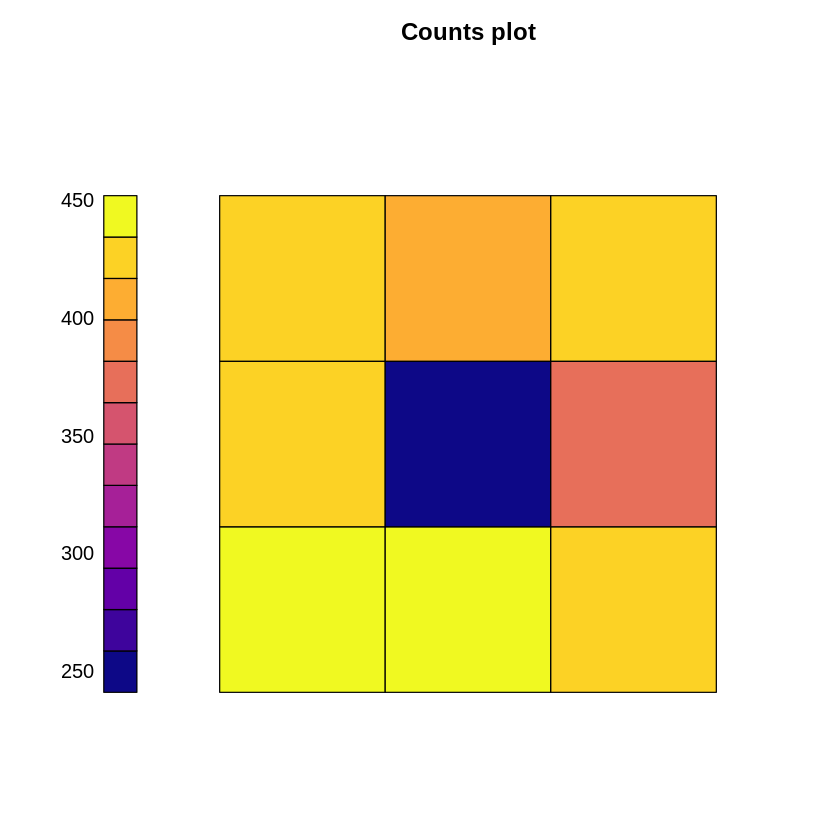

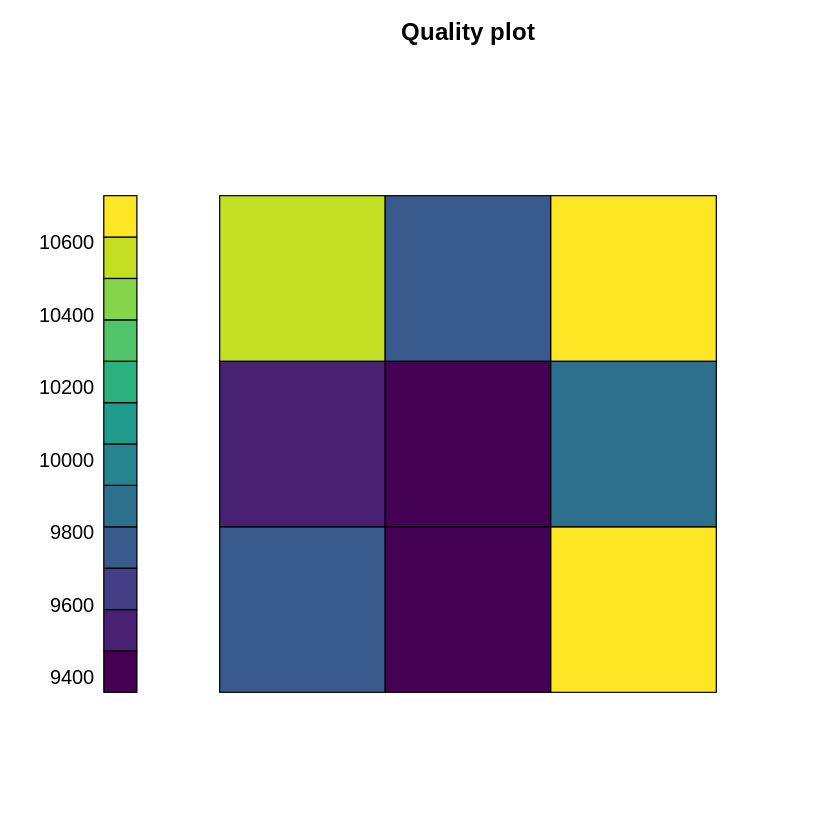

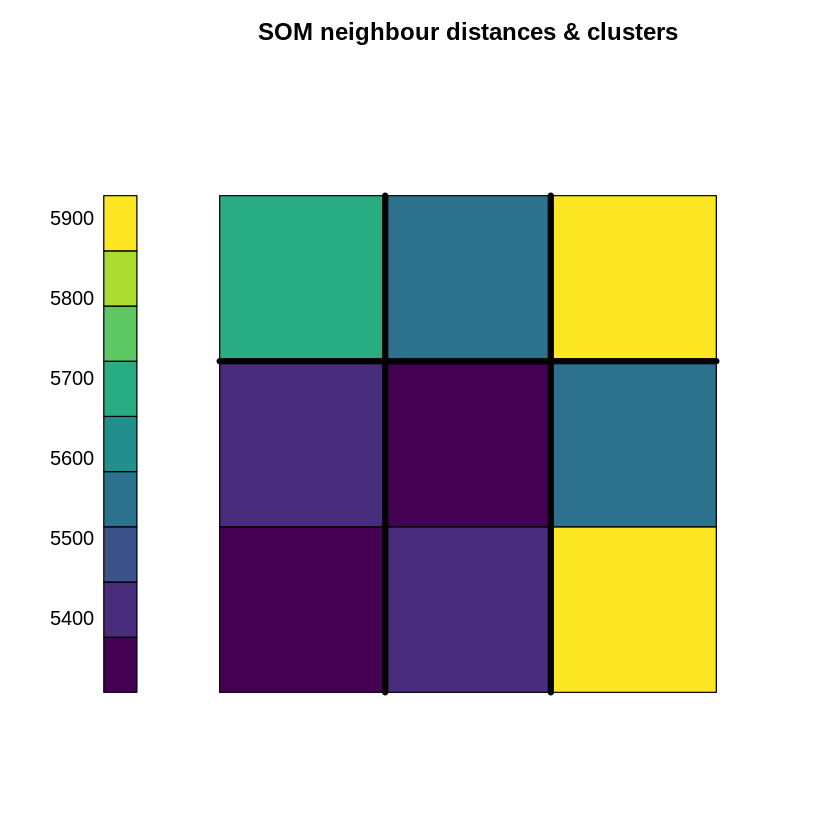

In [ ]:
###OTHER PLOTS AVAILABLE IN KOHONEN PACKAGE

#### quality & count ####
#quality - shows the mean distance mapped to a unit to the codebook vector of that unit. 
# smaller distances = objects (e.g daily z500) represented better by the codebook vectors. 
# counts - number of objects mapped to SOM nodes - frequency?

counts <- plot(K_SOM, type = "counts", 
               palette = plasma, ncolors = 12, 
               shape = "straight")
quality <- plot(K_SOM, type = "quality", 
                palette = viridis, ncolors = 12,
                shape = "straight")

#U matrix/distance neighbours & hierachial clustering
plot(K_SOM,type = "dist.neighbours", 
     main = "SOM neighbour distances & clusters",
     palette = viridis,
     shape = "straight")
#hierarchial clustering to cluster the codebook vectors
som.hc <- cutree(hclust(object.distances(K_SOM,"codes")),6)  #random no. of clusters selected
add.cluster.boundaries(K_SOM, som.hc)